### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sktime as sk
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.utils.plotting import plot_series
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanRelativeAbsoluteError



### Loading dataset from data folder and accessing the data variables

In [2]:
train_data = np.load('data/METR-LA/train.npz')

x_train = train_data['x']


y_train = train_data['y']

### Reshaping the data for proper use

In [3]:
def reshape_func(x):
    x1 = np.reshape(x,(x.shape[0],x.shape[1],-1)) # first merge the sensor with the feature
    x2 = np.reshape(x1,(-1,x1.shape[2]))  # then merge the hours with 5 min intervals
    return x2    

x_train = reshape_func(x_train)
y_train = reshape_func(y_train)

In [4]:
print(x_train.shape)
print(y_train.shape)

(287688, 414)
(287688, 414)


### These new variables are 2D arrays, rows show the time instances while columns show the sensor number and feature. For simplication, let's take only the y instances of first sensor with first feature.

In [5]:
y_train = y_train[:,0]
y_train = pd.DataFrame(y_train)


### Here we load the same variables from the test data and reshape them according to the same process for us to use.

In [6]:
test_data = np.load('data/METR-LA/test.npz')

x_test = test_data['x']
y_test = test_data['y']

x_test = reshape_func(x_test)
y_test = reshape_func(y_test)
print(x_test.shape)
print(y_test.shape)

x_test = x_test[:,0]
y_test = y_test[:,0]

x_test =  pd.DataFrame(x_test)
y_test =  pd.DataFrame(y_test)

#plt.plot(time_test[0:100],output_test[0:100])

(82200, 414)
(82200, 414)


### Here we try some SKTIME basic models

2.5477663504516836e+16
1.9664851036487923


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

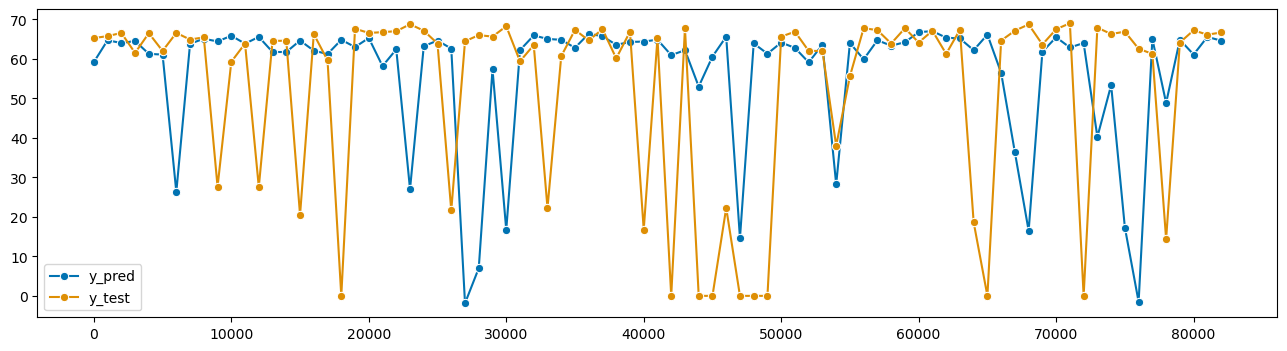

In [7]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster1 = ThetaForecaster(deseasonalize = False)  # hourly seasonal periodicity
forecaster1.fit(y_train)
y_pred = forecaster1.predict(fh)
print(mean_absolute_percentage_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_pred, y_test))
plot_series(y_pred[0::1000],y_test[0::1000],labels = ["y_pred","y_test"])
#plot_series(output_pred,output_test,labels = ["output_pred","output_test"])

### To reduce error due to zero speeds, let's make some changes to the training and testing data


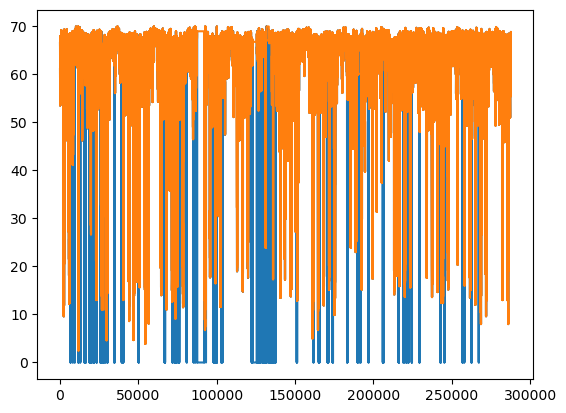

In [8]:
#let's define a function that replaces those values with the last value recorded.

def fillzeros(x):
    x = x.replace(0,np.nan)
    x = x.fillna(method="ffill")
    return x



ytrain_zfill = fillzeros(y_train)
ytest_zfill = fillzeros(y_test)

plt.plot(y_train)
plt.plot(ytrain_zfill)



### Now let us see the error and model performance

### The error reduced drastically but 31.5% is still big error so we do some more smoothings 

0.3157189312051084


(<Figure size 1600x400 with 1 Axes>, <AxesSubplot:>)

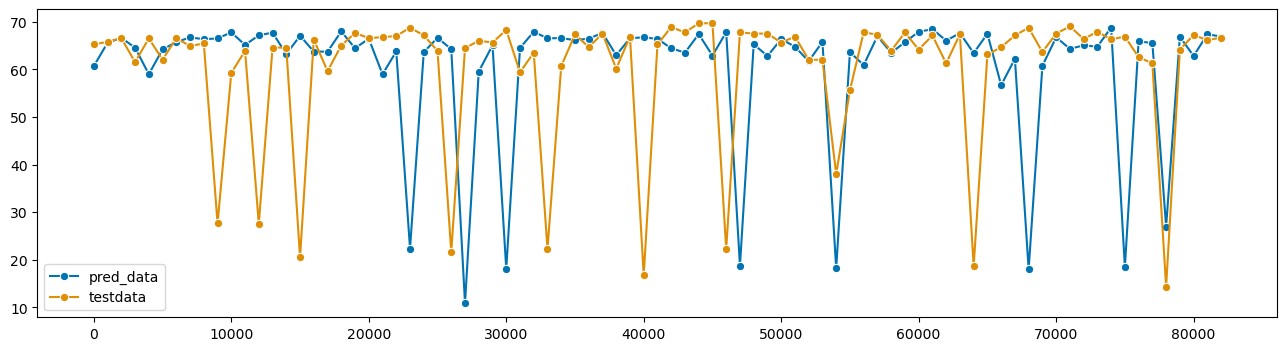

In [13]:
fh2 = ForecastingHorizon(ytest_zfill.index, is_relative=False)
forecaster2 = ThetaForecaster(deseasonalize = False)  # hourly seasonal periodicity
forecaster2.fit(ytrain_zfill)
ypred_zfill = forecaster2.predict(fh2)
print(mean_absolute_percentage_error(ytest_zfill,ypred_zfill))
plot_series(ypred_zfill[0::1000],ytest_zfill[0::1000],labels = ["pred_data","testdata"])
#plot_series(pred_data,testdata,labels = ["pred_data","testdata"])

### We try to remove the trend and seasonality

In [15]:
from sktime.transformations.series.detrend import Detrender,Deseasonalizer

detrender1 = Detrender()
ytrain_detzfill = detrender1.fit_transform(ytrain_zfill)
#plot_series(ytrain_detzfill,ytrain_zfill)

#now we train our model and check the error

forecaster2 = ThetaForecaster(deseasonalize = False)
forecaster2.fit(ytrain_detzfill)
ypred_detzfill = forecaster2.predict(fh)
ypred_zfill_new1 = detrender1.inverse_transform(ypred_detzfill)
print(mean_absolute_percentage_error(ytest_zfill, ypred_zfill_new1))

# the error did not reduce but increased a bit actually

0.31613826018812624


In [17]:
# I do detrending with the data where zeros are not filled

detrender2 = Detrender()
ytrain_det = detrender2.fit_transform(y_train)
forecaster3 = ThetaForecaster(deseasonalize = False)
fh = ForecastingHorizon(y_test.index,is_relative=False)
forecaster3.fit(ytrain_det)
ypred_det = forecaster3.predict(fh)
ypred_new1 = detrender2.inverse_transform(ypred_det)
print(mean_absolute_percentage_error(y_test, ypred_new1))
print(mean_absolute_percentage_error(ypred_new1, y_test))

# the detrending here does not help at all.

2.6227970058954064e+16
4743.86715402923


In [18]:
# Trying to do deseasonalizing with and without zeros

deseasonal1 = Deseasonalizer()
ytrain_des = deseasonal1.fit_transform(y_train)
forecaster = ThetaForecaster(deseasonalize = False)
fh = ForecastingHorizon(y_test.index,is_relative=False)
forecaster.fit(ytrain_des)
ypred_des = forecaster.predict(fh)
ypred_new2 = deseasonal1.inverse_transform(ypred_des)
print(mean_absolute_percentage_error(y_test, ypred_new2))
print(mean_absolute_percentage_error(ypred_new2, y_test))


print ("Now without zeros")


deseasonal2 = Deseasonalizer(sp=288)
ytrain_deszfill = deseasonal2.fit_transform(ytrain_zfill)
forecaster = ThetaForecaster(deseasonalize = False)
fh = ForecastingHorizon(ytest_zfill.index,is_relative=False)
forecaster.fit(ytrain_deszfill)
ypred_deszfill = forecaster.predict(fh)
ypred_zfill_new2 = deseasonal2.inverse_transform(ypred_deszfill)
print(mean_absolute_percentage_error(ytest_zfill, ypred_zfill_new2))
#print(mean_absolute_percentage_error(ypred_new2, y_test))

## since the error is exactly same I believe the deseasonalizer has not worked.


2.5477663504516836e+16
1.9664851036487923
Now without zeros
0.31574232872940744
